In [1]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMRegressor
from pathlib import Path
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from mentorship.features.kaggle.storesales.etl import ETLTransformer
from mentorship.features.history import cut_history
from mentorship.features.tuning import boruta_features_tuning
from mentorship.ml.cv.kaggle.storesales.split import DateTimeSeriesSplit
from mentorship.ml.cv.util import format_cv_test_scores
from mentorship.ml.models.kaggle.storesales.hyperparams.tuning import tune_hyperparams
from mentorship.ml.models.kaggle.storesales.boosting import LGBMPipeline
from mentorship.ml.models.kaggle.storesales.linear import LinearPipeline
from mentorship.ml.models.common import RecursiveTSEstimator
from mentorship.ml.tools.kaggle.storesales.submission import make_submission_file
from mentorship.ml.tools.kaggle.storesales.curves import plot_learning_curver


%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
CV_METRICS = [
    'neg_mean_squared_log_error',
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error',
    'r2'
]

In [5]:
DATA_ROOT = Path('data', 'kaggle', 'store-sales-time-series-forecasting')

In [6]:
train = pd.read_csv(DATA_ROOT / 'train.csv')
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [7]:
N_STORES = train['store_nbr'].nunique()
N_FAMILIES = train['family'].nunique()
N_TIME_SERIES = N_STORES * N_FAMILIES

DAYS_IN_YEAR = 365
N_HORIZONS = 16

In [8]:
def plot_multiple_barplot(data, x, y, hue, figsize=(20, 10)):
    fig = plt.figure(figsize=(figsize))
    sns.barplot(data=data, x=x, y=y, hue=hue, ci=None)
    plt.xticks(rotation=90)
    plt.show()

# 0.1 test (linear regression with best lags)

In [9]:
# ETL stage for the train data

lags = [1, 2, 4, 6, 7, 14]

X = train.copy()
train_transformer = ETLTransformer(lags=lags, target_col='sales', use_rmsle=False)
X, y = train_transformer.transform(X)

X.head()

date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0  2013-01-01          1  automotive    0.0            0         NaN   
1  2013-01-01          1   baby care    0.0            0         NaN   
2  2013-01-01          1      beauty    0.0            0         NaN   
3  2013-01-01          1   beverages    0.0            0         NaN   
4  2013-01-01          1       books    0.0            0         NaN   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_6  sales_lag_7  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   sales_lag_14  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [10]:
# cross validation

splitter = DateTimeSeriesSplit()
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                    level='store_nbr', drop_columns=['onpromotion'], lags=lags, 
                                                    split_key='family', target_col='sales', use_rmsle=False)

modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales')

In [11]:
scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise', 
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.469 ± 0.019
root_mean_squared_error: 278.087 ± 23.840
mean_absolute_error: 78.055 ± 6.096
r2: 0.954 ± 0.008


In [12]:
# getting X_train and y_train for the final model training

X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [13]:
# ETL stage for the test data

test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(is_test=True)
test_data = test_transformer.transform(test_data)
test_data.head()

date  store_nbr      family  onpromotion  dcoilwtico
0  2017-08-16          1  automotive            0        46.8
1  2017-08-16          1   baby care            0        46.8
2  2017-08-16          1      beauty            2        46.8
3  2017-08-16          1   beverages           20        46.8
4  2017-08-16          1       books            0        46.8

In [14]:
# fitting the final model and making submission file

modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, modelling_pipeline, 'linreg_with_recursive_lags1.csv')

# 0.2 test (LGBMRegressor with default params, same features)

In [15]:
lags = [1, 2, 4, 6, 7, 14]

X = train.copy()

train_transformer = ETLTransformer(lags=lags, target_col='sales')
X, y = train_transformer.transform(X)
splitter = DateTimeSeriesSplit()

X.head()

date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0  2013-01-01          1  automotive    0.0            0         NaN   
1  2013-01-01          1   baby care    0.0            0         NaN   
2  2013-01-01          1      beauty    0.0            0         NaN   
3  2013-01-01          1   beverages    0.0            0         NaN   
4  2013-01-01          1       books    0.0            0         NaN   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_6  sales_lag_7  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   sales_lag_14  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

root_mean_squared_log_error: 0.459 ± 0.022
root_mean_squared_error: 271.186 ± 34.090
mean_absolute_error: 72.590 ± 8.938
r2: 0.955 ± 0.011


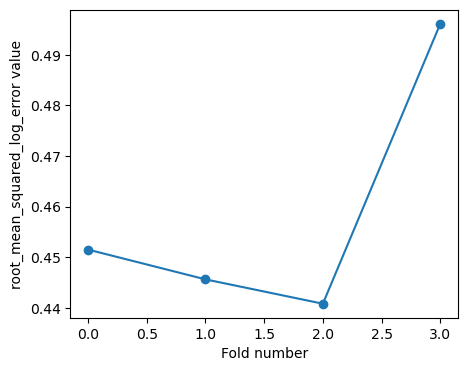

In [16]:
params = {'categorical_feature': [0]}
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                  target_col='sales', level=['store_nbr'], params=params)
modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales')

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['root_mean_squared_log_error'])

In [17]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [18]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(is_test=True)
test_data = test_transformer.transform(test_data)
test_data.head()

date  store_nbr      family  onpromotion  dcoilwtico
0  2017-08-16          1  automotive            0        46.8
1  2017-08-16          1   baby care            0        46.8
2  2017-08-16          1      beauty            2        46.8
3  2017-08-16          1   beverages           20        46.8
4  2017-08-16          1       books            0        46.8

In [19]:
modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, modelling_pipeline, 'default_LGBM_with_recursive_lags2.csv')

# 1. Experiments with LGBMRegressor for every family

In [20]:
lags = [1, 2, 4, 6, 7, 14]

X = train.copy()
y = X['sales'].copy()

train_transformer = ETLTransformer(lags=lags, target_col='sales')
X, y = train_transformer.transform(X)
splitter = DateTimeSeriesSplit()

X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

X.head()

date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0  2013-01-01          1  automotive    0.0            0         NaN   
1  2013-01-01          1   baby care    0.0            0         NaN   
2  2013-01-01          1      beauty    0.0            0         NaN   
3  2013-01-01          1   beverages    0.0            0         NaN   
4  2013-01-01          1       books    0.0            0         NaN   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_6  sales_lag_7  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   sales_lag_14  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [21]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(is_test=True)
test_data = test_transformer.transform(test_data)
test_data.head()

date  store_nbr      family  onpromotion  dcoilwtico
0  2017-08-16          1  automotive            0        46.8
1  2017-08-16          1   baby care            0        46.8
2  2017-08-16          1      beauty            2        46.8
3  2017-08-16          1   beverages           20        46.8
4  2017-08-16          1       books            0        46.8

#### Compare scores for each family (linear regression and simplest lgbm regressor)

In [22]:
final_scores_linear, final_scores_lgbm = {}, {}
for current_family in X['family'].unique():
    X_current_family = X[X['family'] == current_family]
    y_current_family = y.loc[X_current_family.index]
    
    base_linear_pipeline = {current_family:LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                           drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                           target_col='sales')}
    modelling_pipeline_linear = RecursiveTSEstimator(base_pipelines=base_linear_pipeline, split_key='family', target_col='sales')

    fit_params_lgbm = {'categorical_feature': [0]}
    base_lgbm_pipeline = {current_family:LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params_lgbm)}
    modelling_pipeline_lgbm = RecursiveTSEstimator(base_pipelines=base_lgbm_pipeline, split_key='family', target_col='sales')
    
    scores_linear = cross_validate(modelling_pipeline_linear, X_current_family, y_current_family, cv=splitter, 
                                   scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
    scores_lgbm = cross_validate(modelling_pipeline_lgbm, X_current_family, y_current_family, cv=splitter, 
                                 scoring=CV_METRICS, return_estimator=True, error_score='raise', n_jobs=-1)
    
    final_scores_linear[current_family] = format_cv_test_scores(scores_linear, save_scores=True, print_scores=False)
    final_scores_lgbm[current_family] = format_cv_test_scores(scores_lgbm, save_scores=True, print_scores=False)

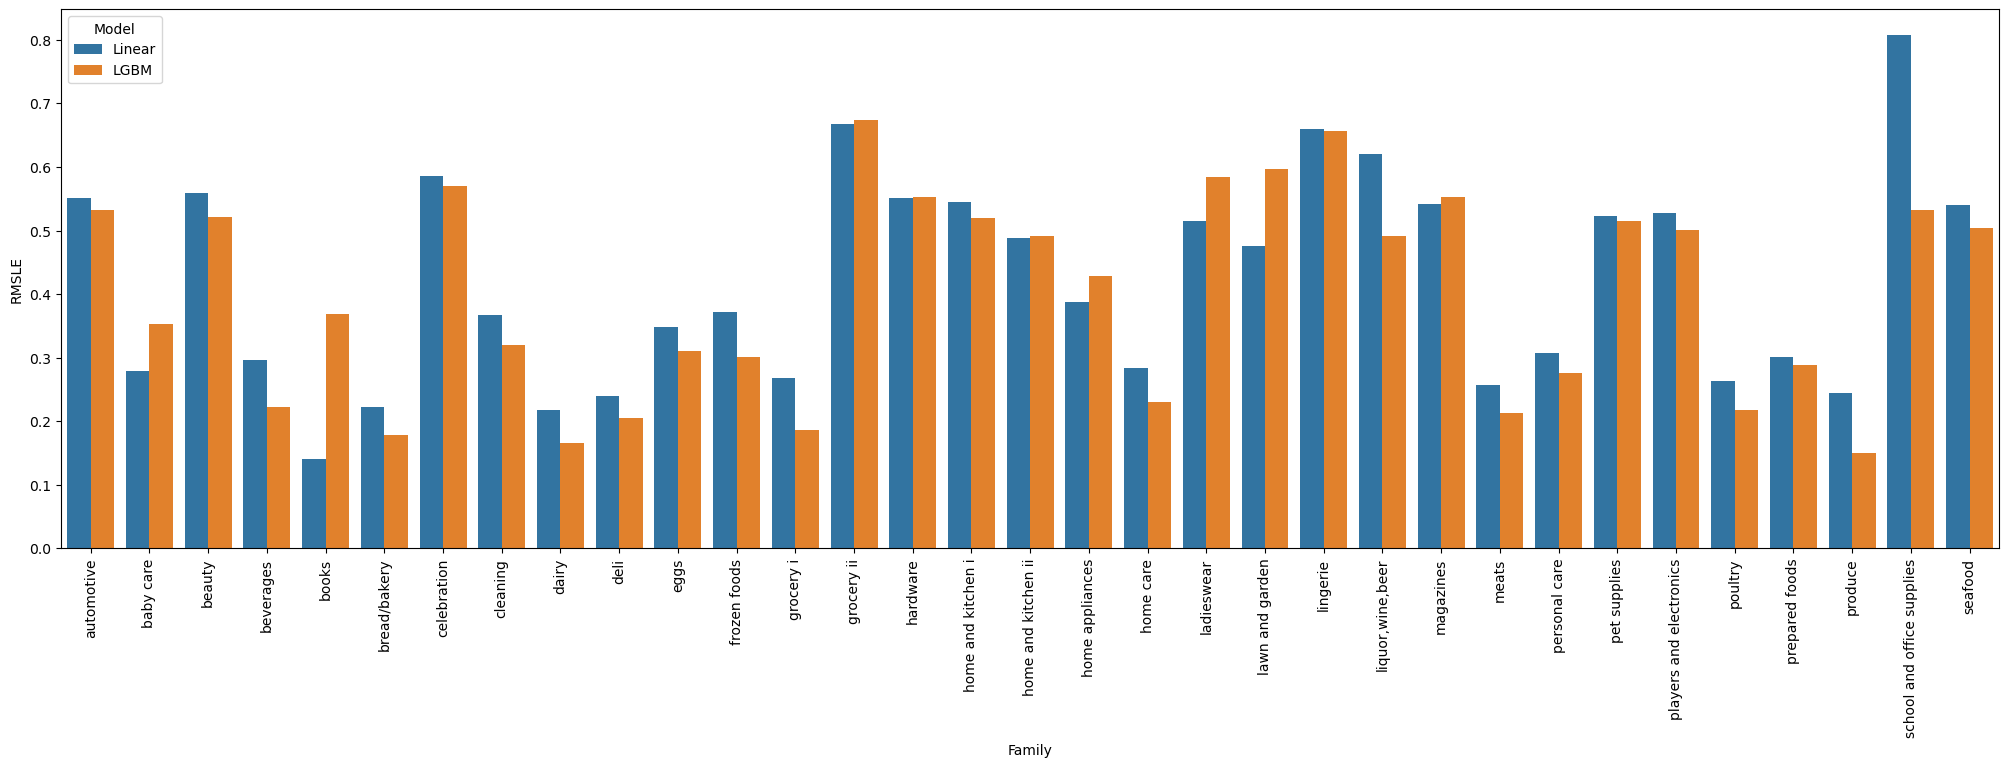

In [23]:
compare_df = pd.DataFrame({'Family': list(final_scores_linear.keys()) * 2, 
                           'Model': ['Linear'] * len(final_scores_linear.keys()) + ['LGBM'] * len(final_scores_lgbm.keys()),
                           'RMSLE': [final_scores_linear[key][0]['root_mean_squared_log_error'] for key in final_scores_linear.keys()] + 
                                    [final_scores_lgbm[key][0]['root_mean_squared_log_error'] for key in final_scores_lgbm.keys()]})
plot_multiple_barplot(data=compare_df, x='Family', y='RMSLE', hue='Model', figsize=(25, 7))

<p><i>'books' family will be fitted with LinearRegression (because of big difference in scores and anomalous distribution)</i>

#### Learning curves for default lgbm (metric: 'msle')

In [24]:
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)

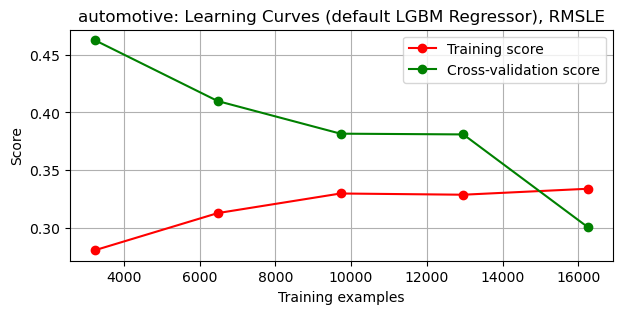

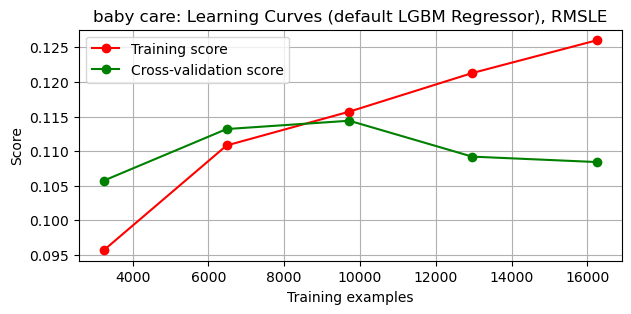

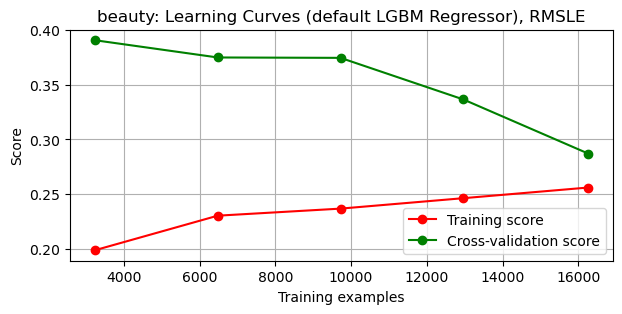

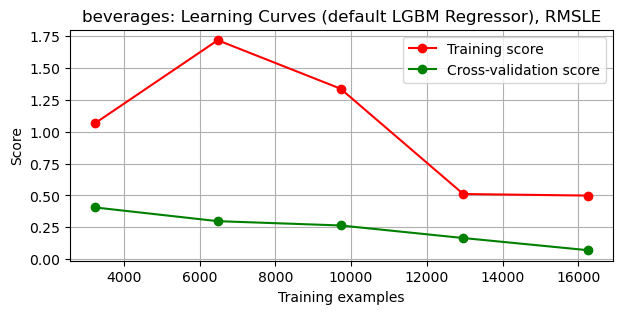

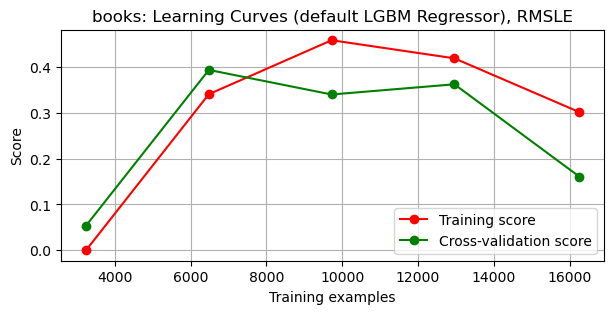

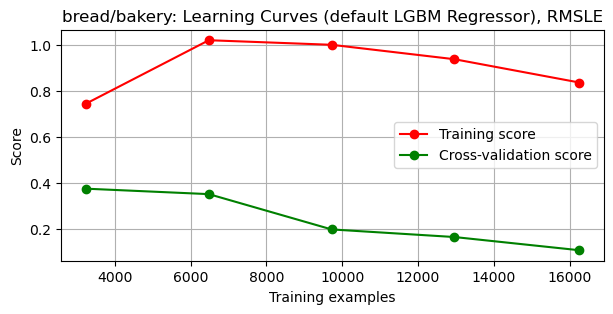

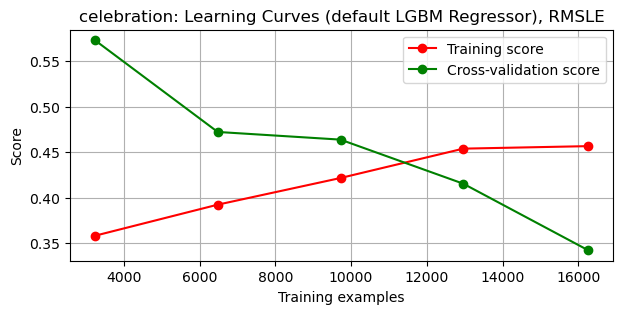

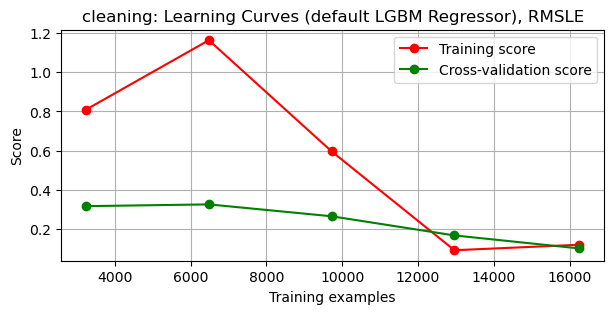

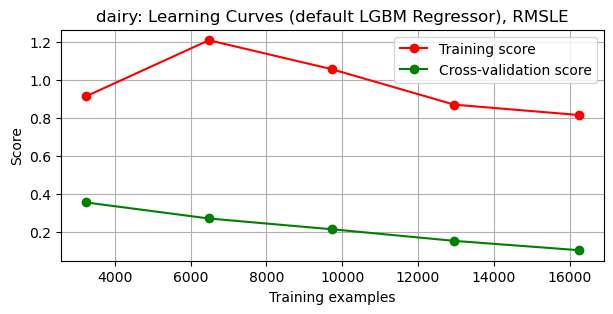

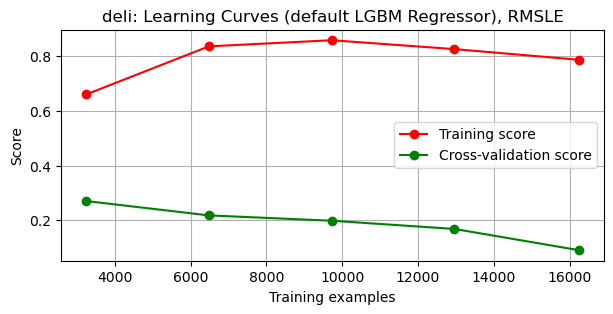

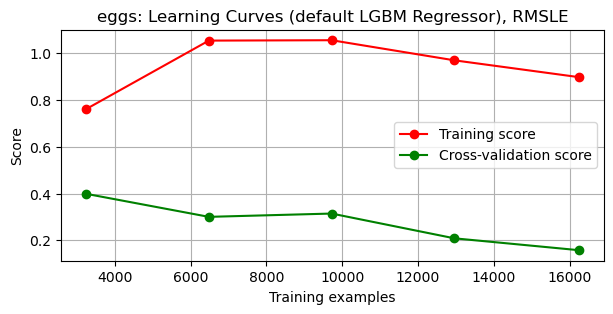

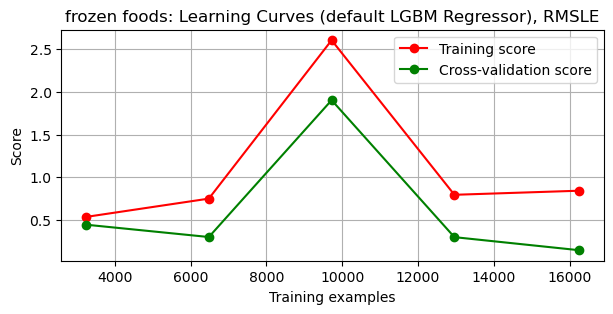

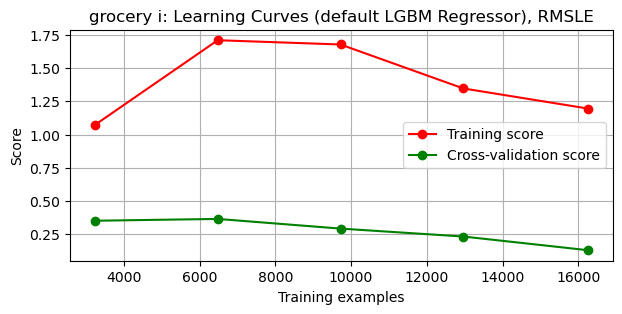

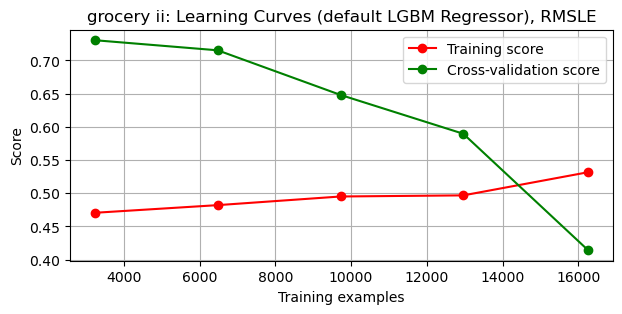

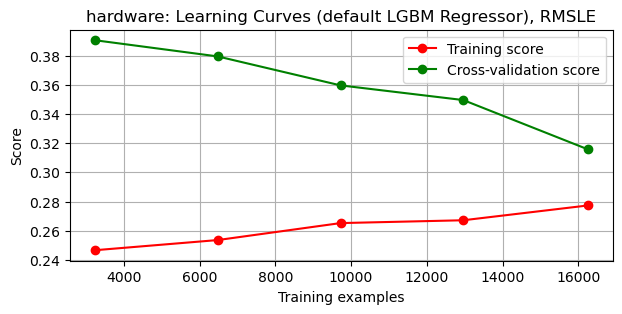

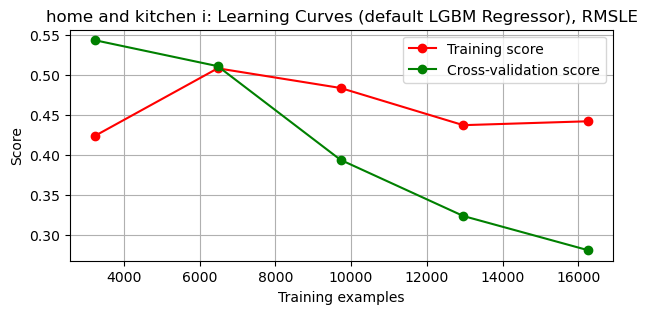

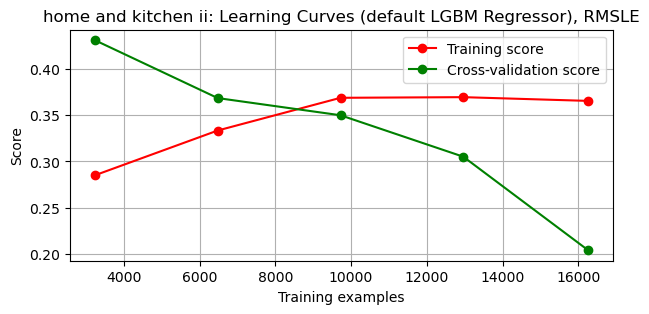

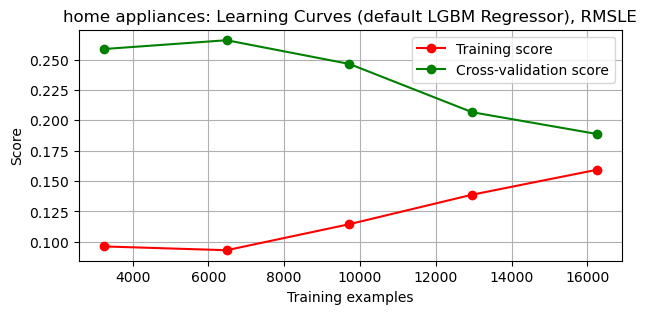

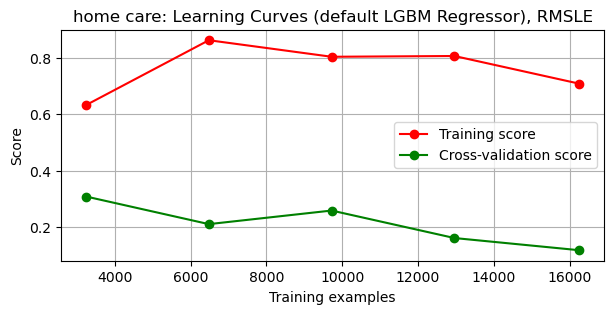

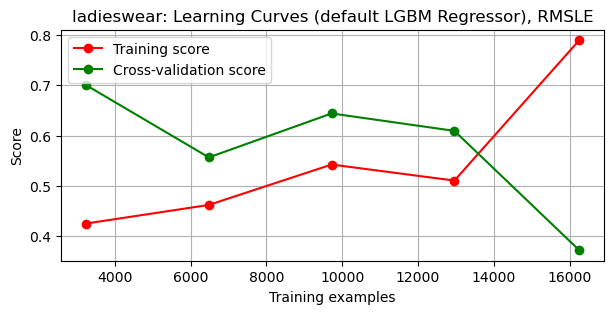

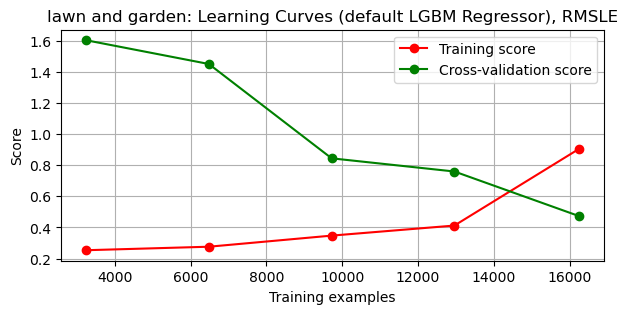

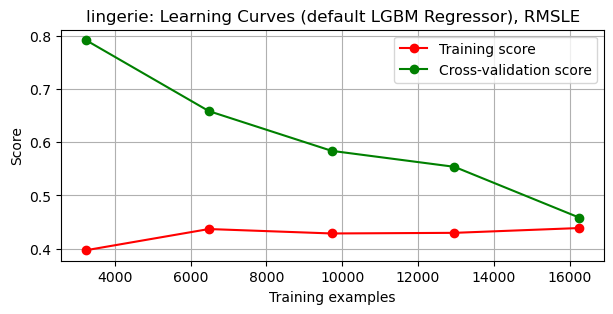

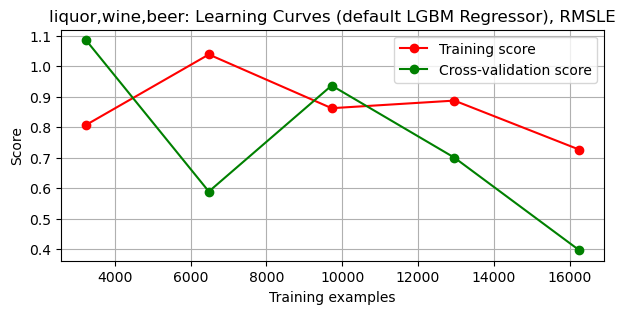

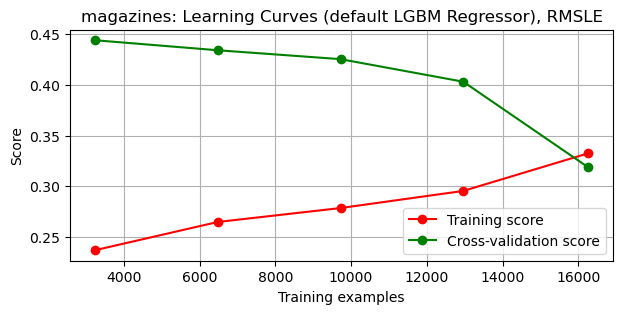

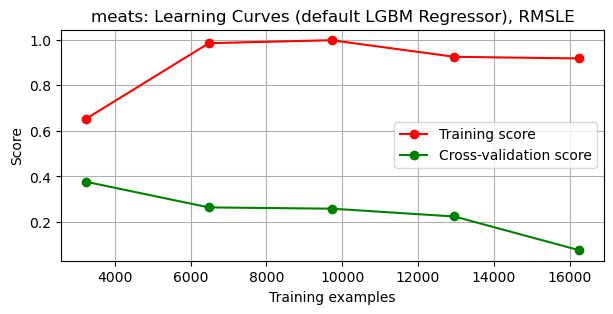

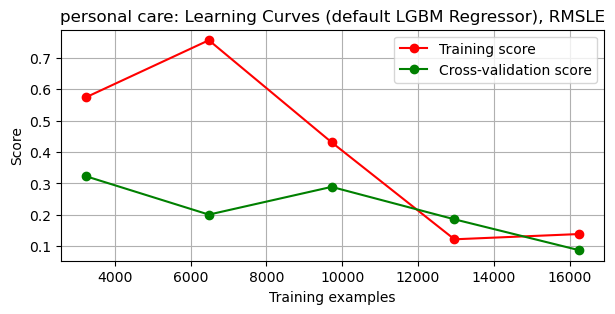

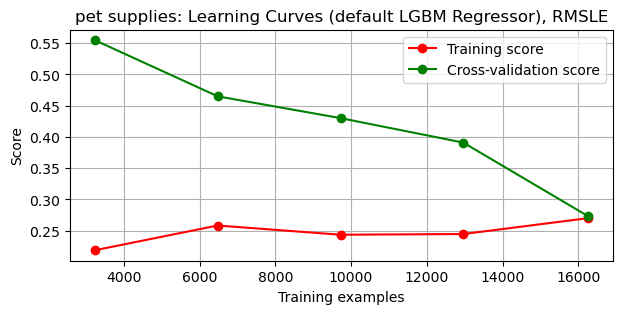

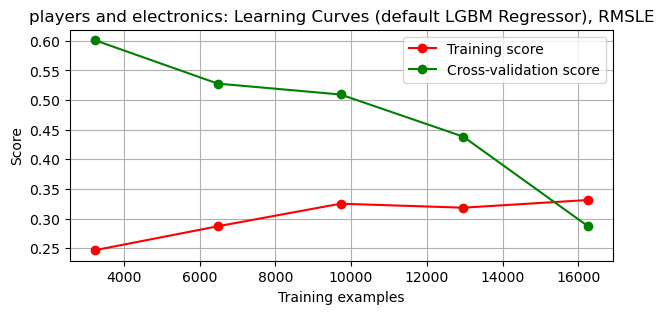

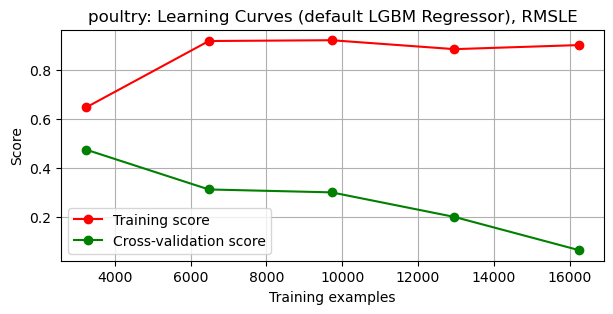

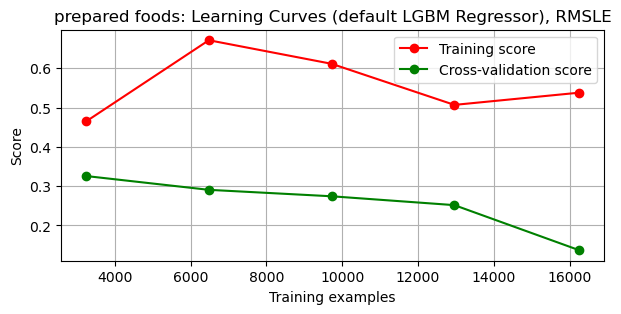

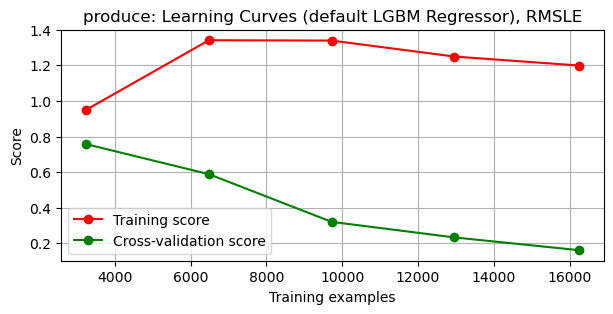

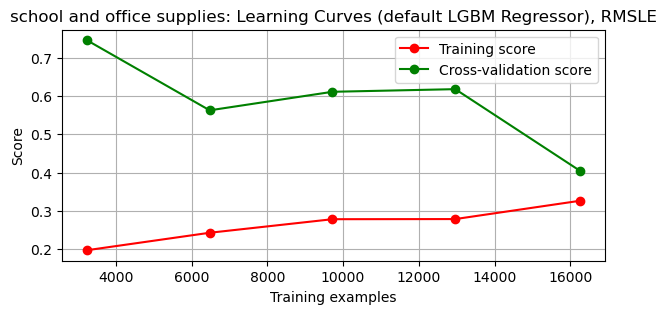

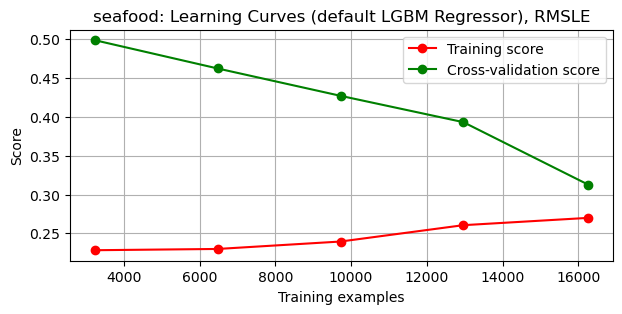

In [25]:
train_sizes = [60 * N_STORES, 120 * N_STORES, 180 * N_STORES, 240 * N_STORES, 301 * N_STORES]
plot_learning_curver(X, y, tscv_inner=tscv_inner, train_sizes=train_sizes, lags=lags)

#### Hyperparameters tuning with Optuna

In [26]:
# hyperparameters tuning (for cross validation)

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

best_cv_params = tune_hyperparams(X_train_first_fold, y_train_first_fold, tscv_inner=tscv_inner, lags=lags,
                                  fit_params={'categorical_feature': [0]}, use_rmsle=True)

#### Looking for 'zero'-families

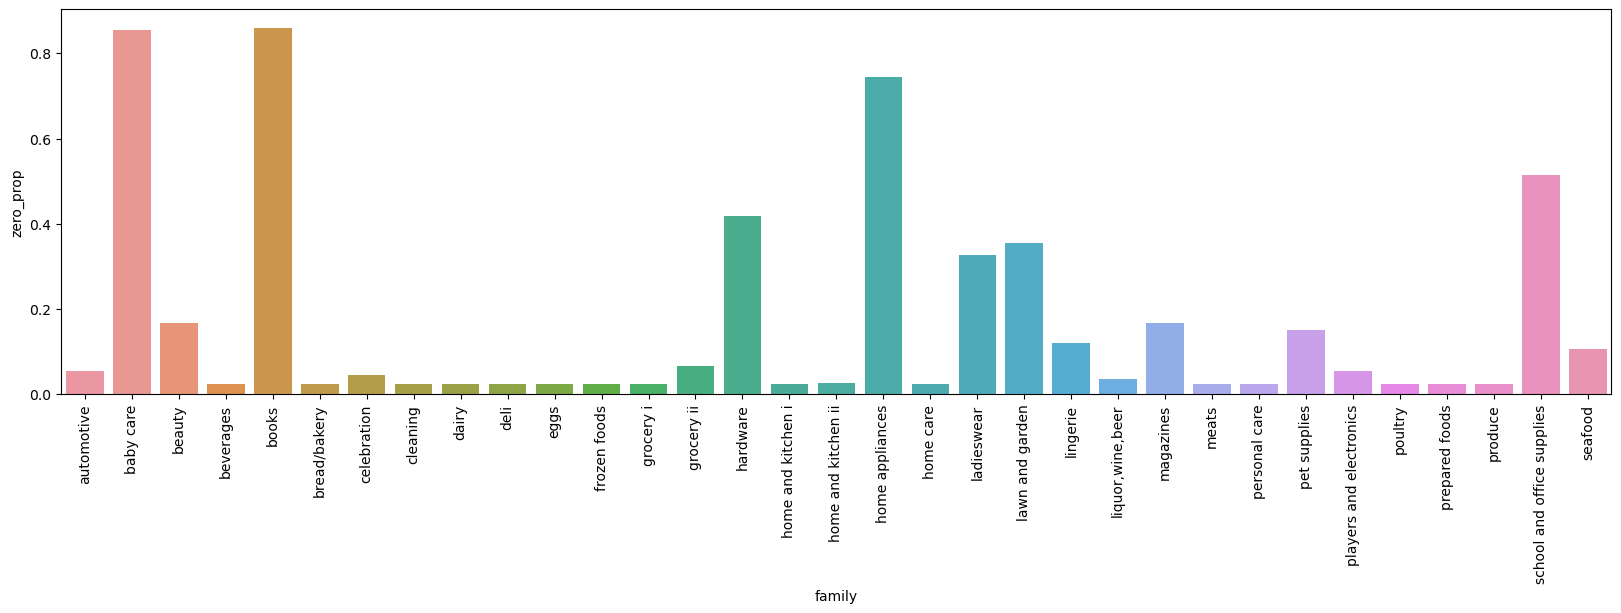

In [27]:
zero_prop = {}
for current_family in X_train['family'].unique():
    X_current_family = X_train[X_train['family'] == current_family]
    zero_prop[current_family] = (X_current_family["sales"] == 0).mean()
zero_prop_data = pd.DataFrame({'family': list(zero_prop.keys()), 'zero_prop': list(zero_prop.values())})
    
plt.figure(figsize=(20, 5))
sns.barplot(data=zero_prop_data, x='family', y='zero_prop')
plt.xticks(rotation=90)
plt.show()

<p><b>Let's try 'baby care' and 'books' predictions set to 0.</b></p>

In [28]:
zero_categories=['baby care', 'books']

root_mean_squared_log_error: 0.424 ± 0.007
root_mean_squared_error: 275.805 ± 21.478
mean_absolute_error: 73.778 ± 5.069
r2: 0.954 ± 0.007


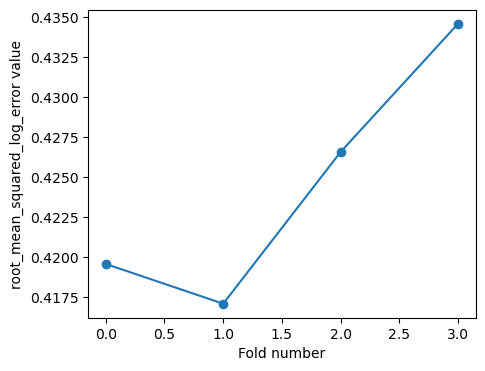

In [29]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                  params=best_cv_params[current_family], fit_params=fit_params)
modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales',
                                          zero_categories=zero_categories)

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
format_cv_test_scores(scores, metrics_to_plot=['root_mean_squared_log_error'])

In [30]:
### best params for final model (nested cross validation on X_train, y_train)

best_final_params = tune_hyperparams(X_train, y_train, tscv_inner=tscv_inner, lags=lags, use_rmsle=True,
                                     fit_params={'categorical_feature': [0]})

In [31]:
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   params=best_final_params[current_family], fit_params=fit_params)

final_modelling_pipeline = RecursiveTSEstimator(base_pipelines=base_pipelines, split_key='family', target_col='sales',
                                                 zero_categories=zero_categories)
final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM.csv')

### Score on Kaggle: 0.42286

### LinearRegression and LGBMRegressor combining 

#### Learning curves for lgbm with tuned parameters (metric 'msle')

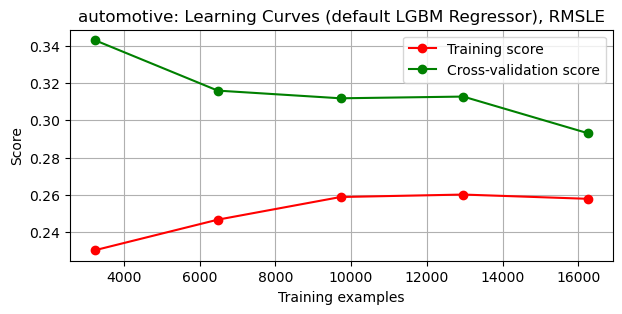

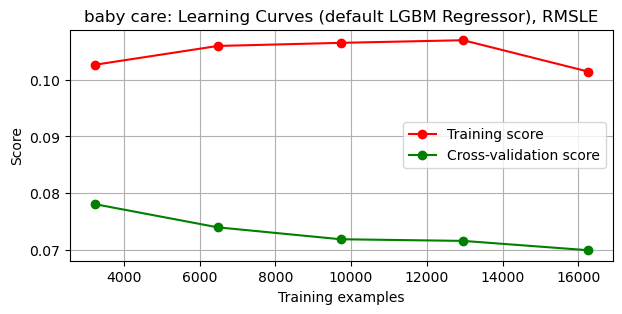

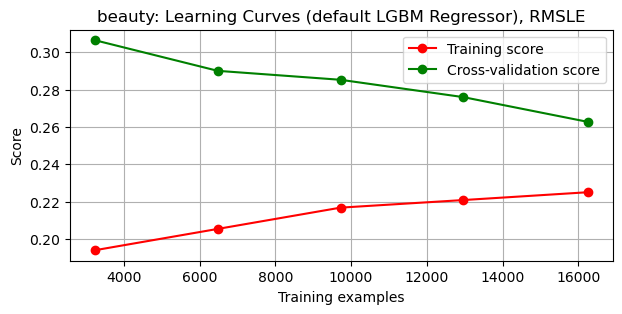

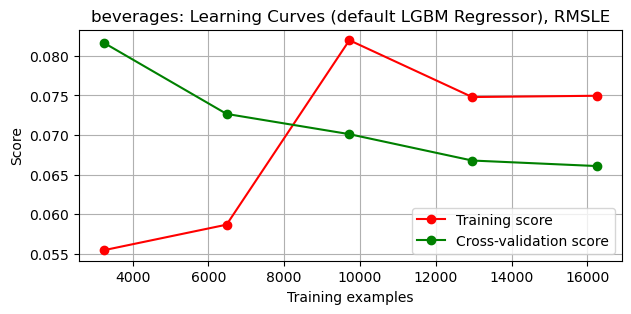

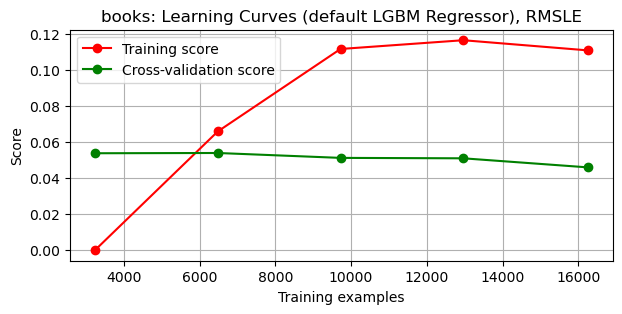

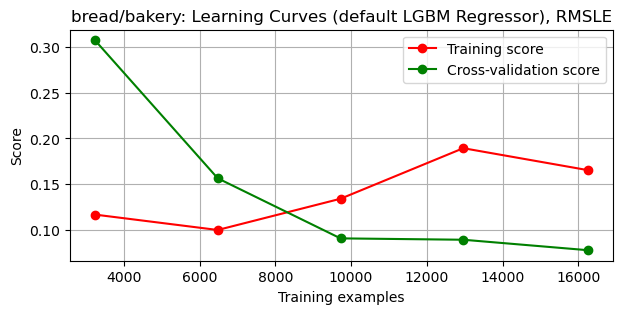

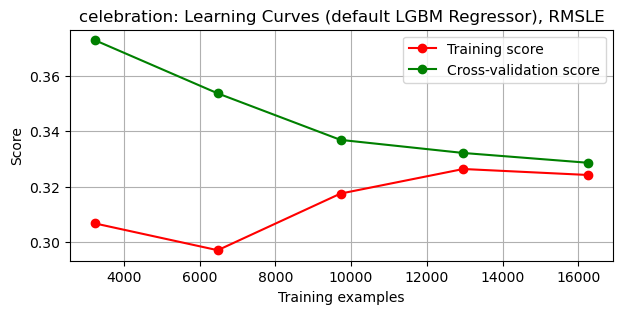

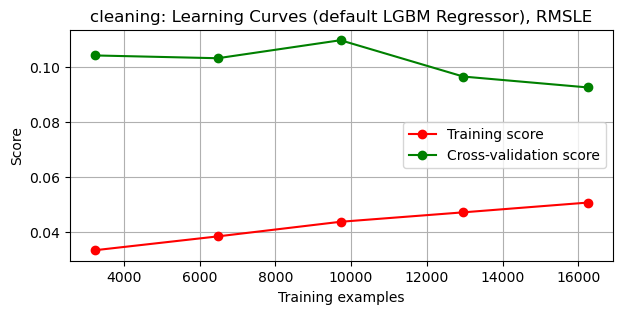

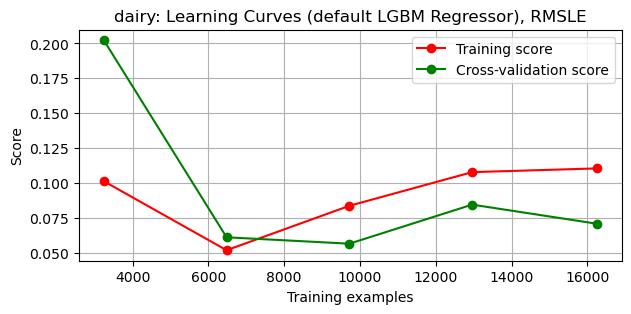

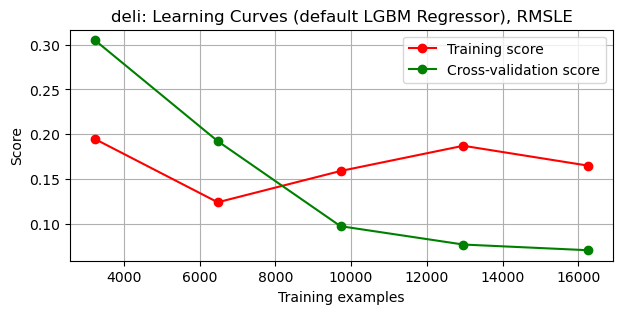

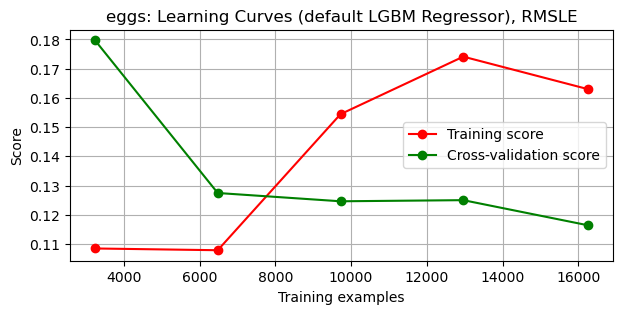

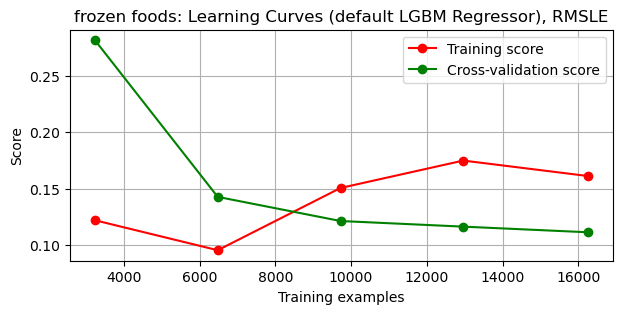

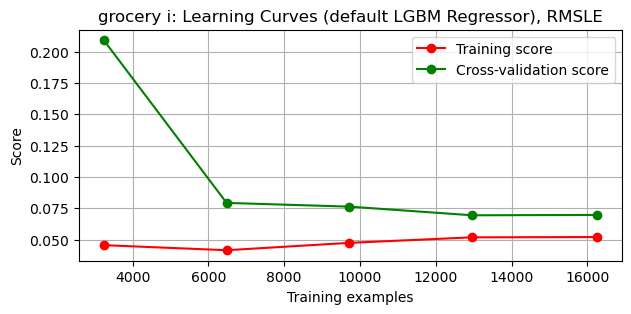

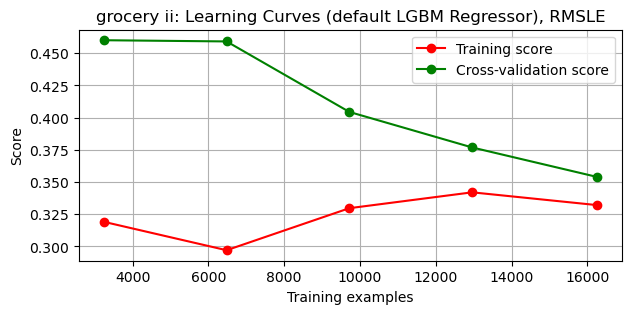

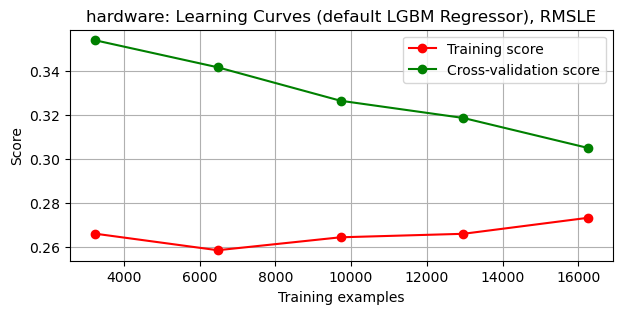

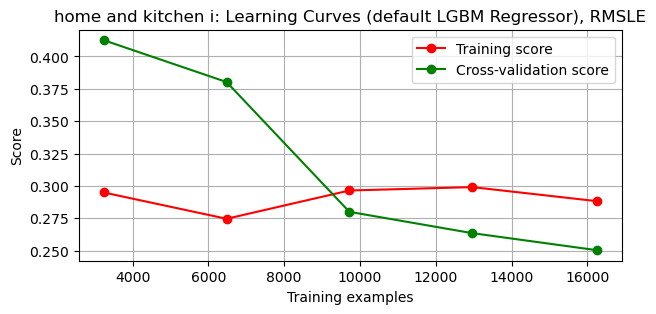

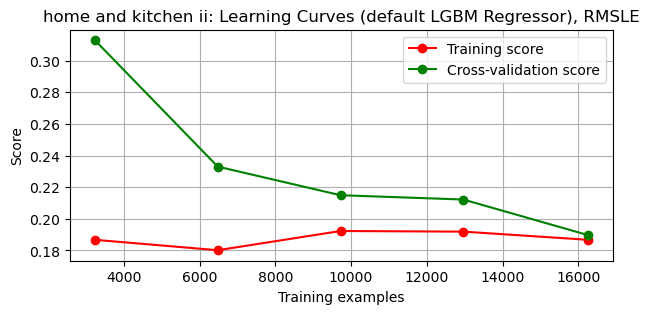

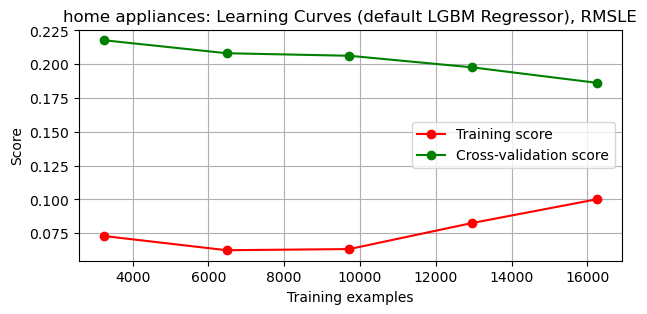

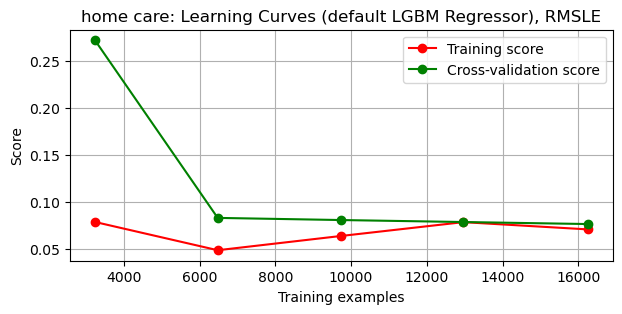

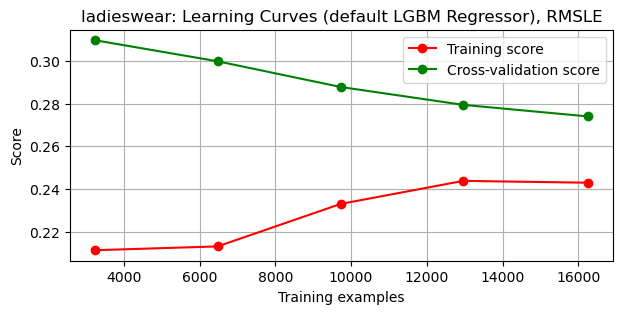

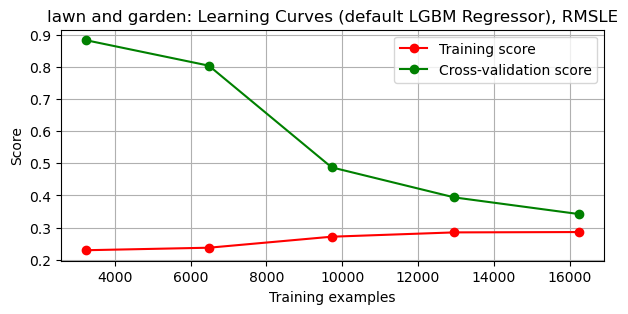

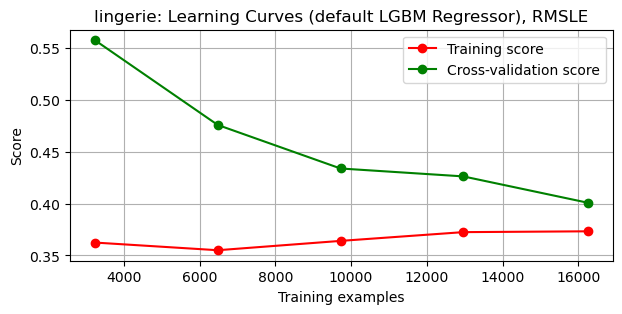

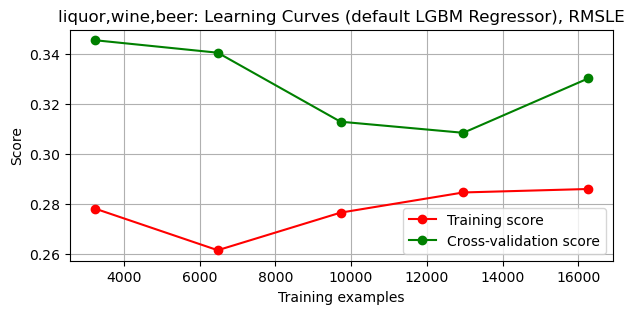

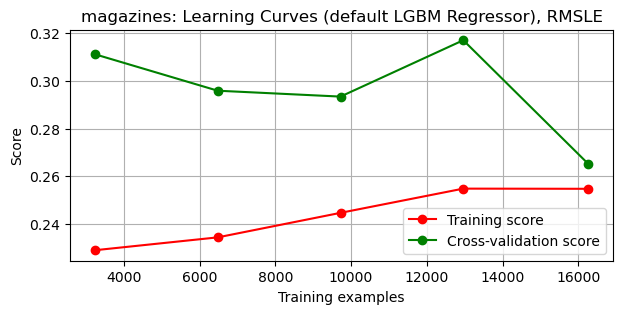

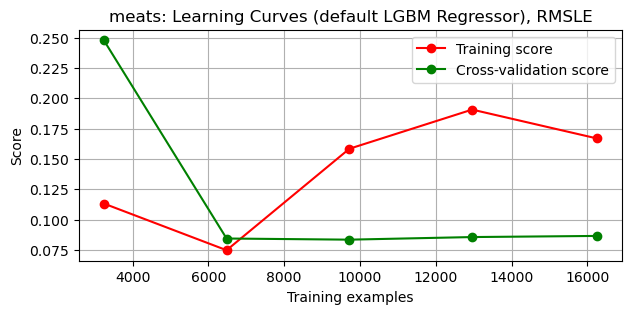

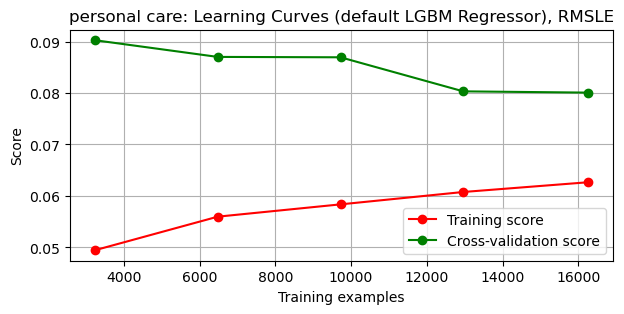

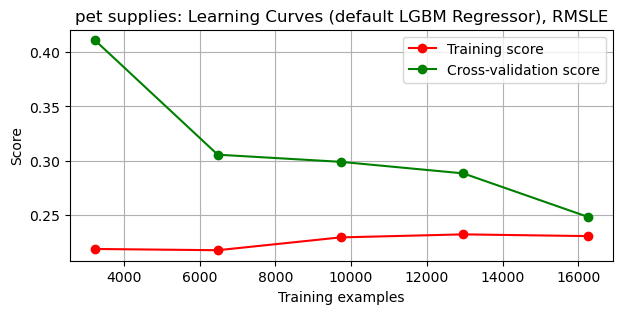

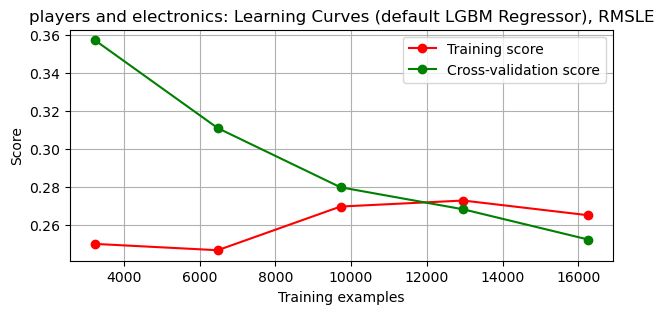

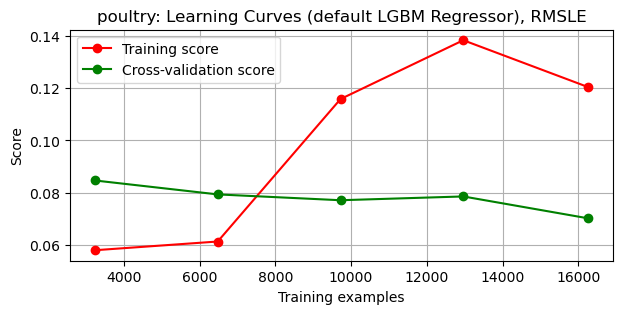

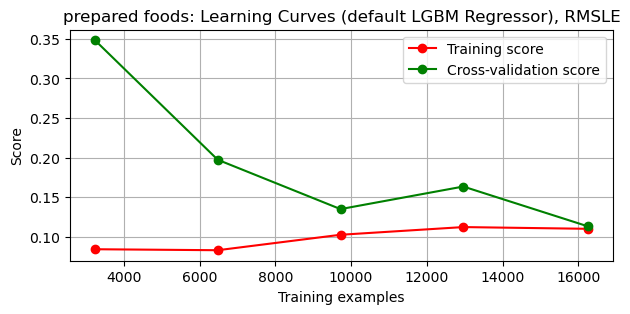

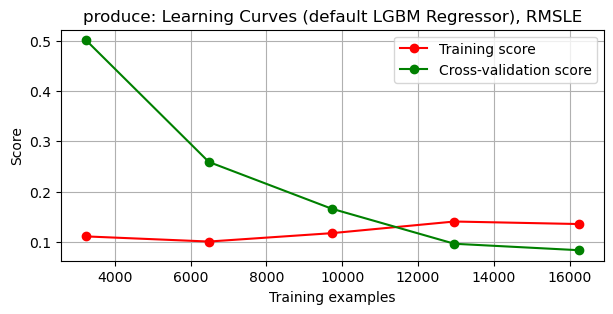

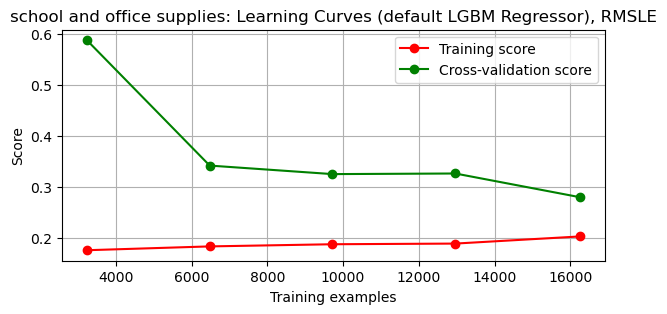

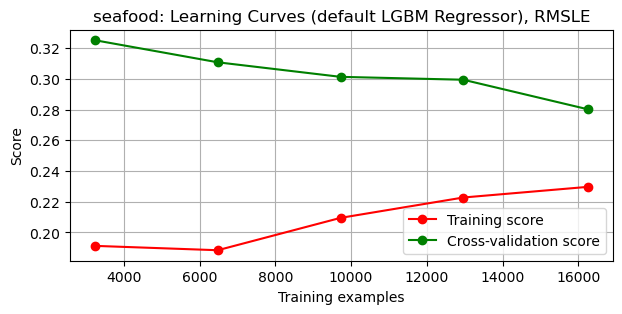

In [32]:
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
train_sizes = [60 * N_STORES, 120 * N_STORES, 180 * N_STORES, 240 * N_STORES, 301 * N_STORES]
plot_learning_curver(X, y, params=best_cv_params, tscv_inner=tscv_inner, train_sizes=train_sizes)

In [33]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                        drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                        target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                      fit_params=fit_params, params=best_cv_params[current_family])


modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                          zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.422 ± 0.004
root_mean_squared_error: 275.806 ± 21.477
mean_absolute_error: 73.788 ± 5.063
r2: 0.954 ± 0.007


In [34]:
base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_final_params[current_family])

final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                                 zero_categories=['baby care', 'books'])
final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM_and_linreg.csv')

### Score on Kaggle: 0.4185

### Adding feature selection 

#### Feature importance in default LGBMRegressor (for every family)

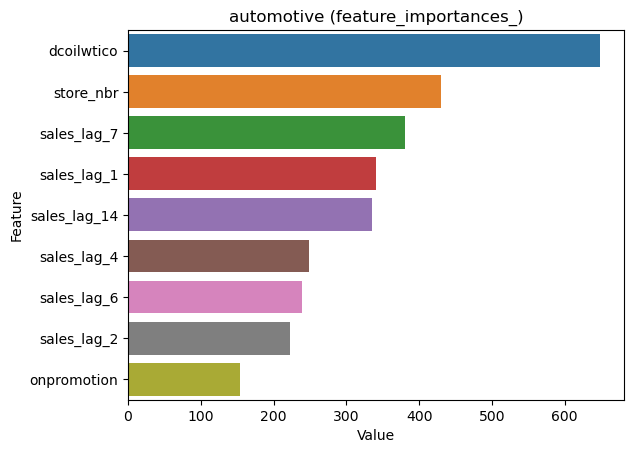

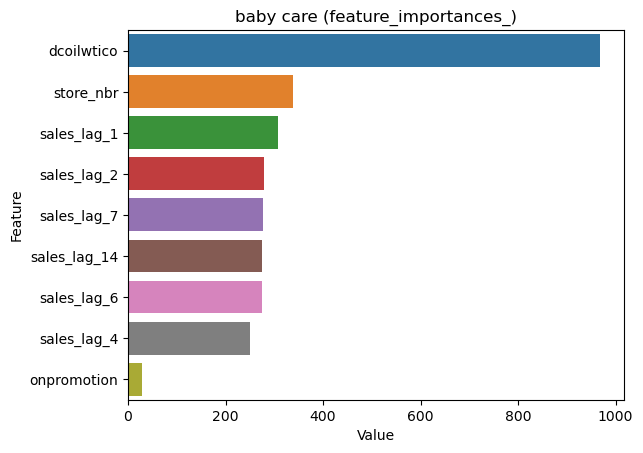

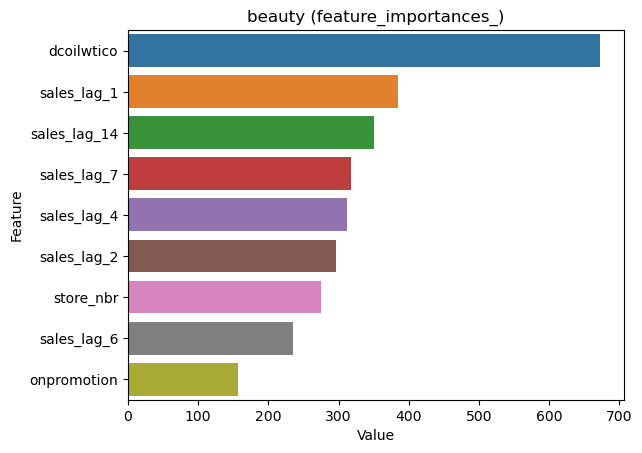

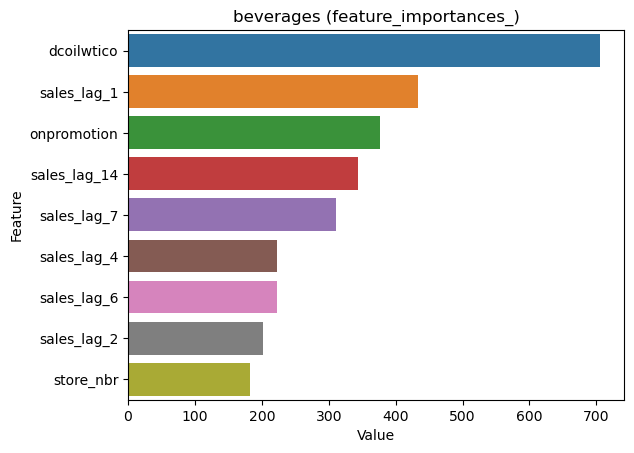

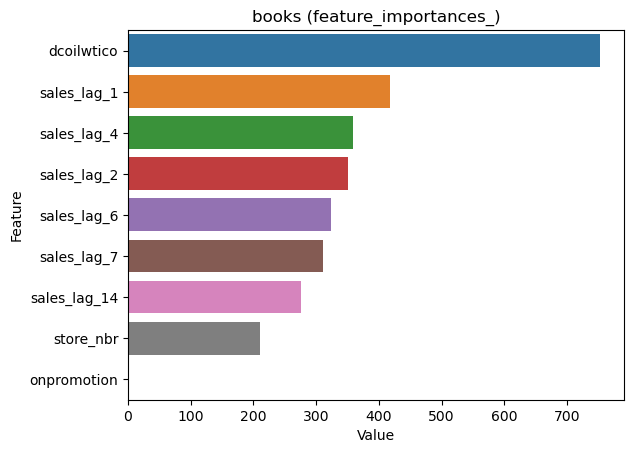

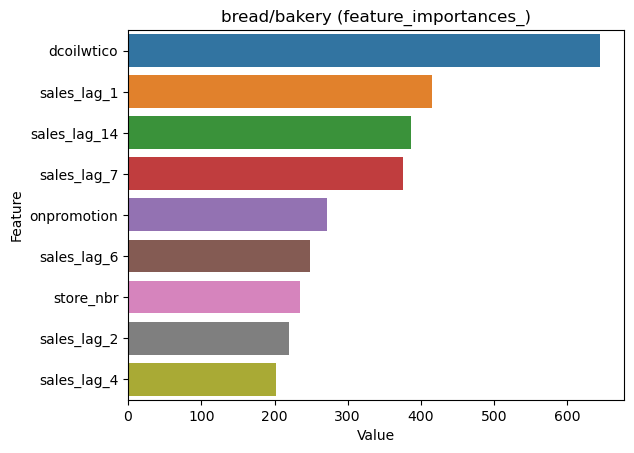

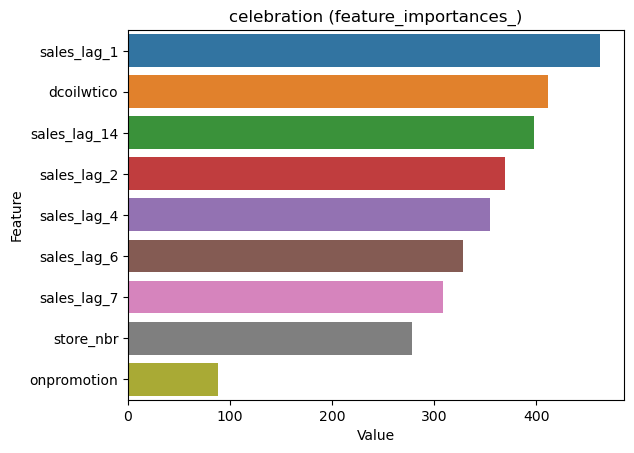

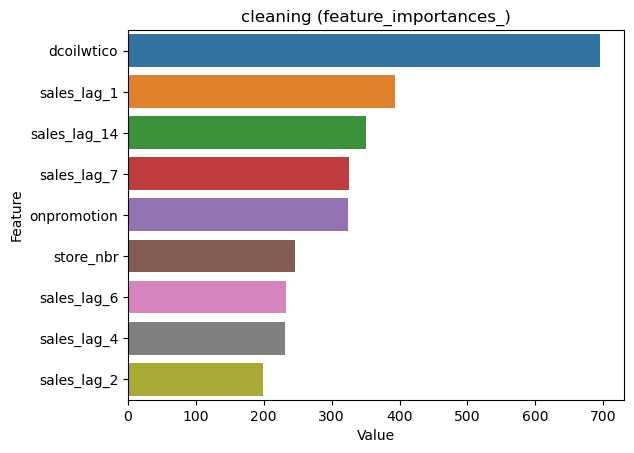

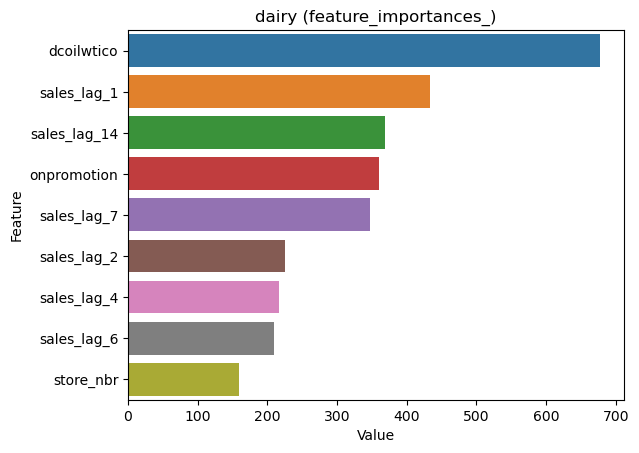

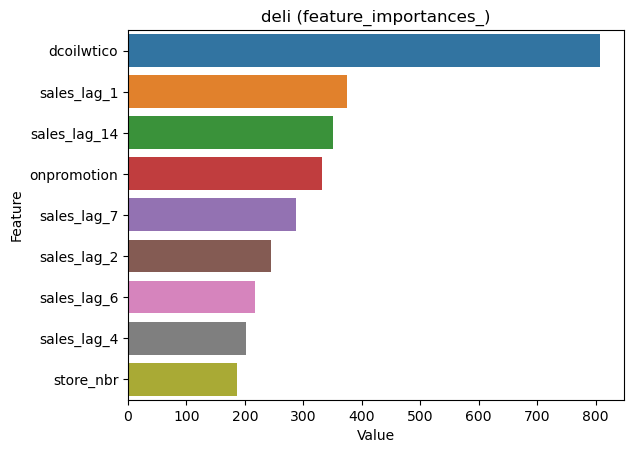

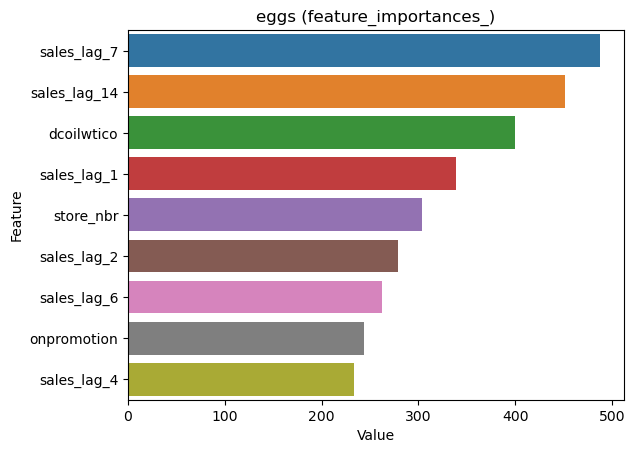

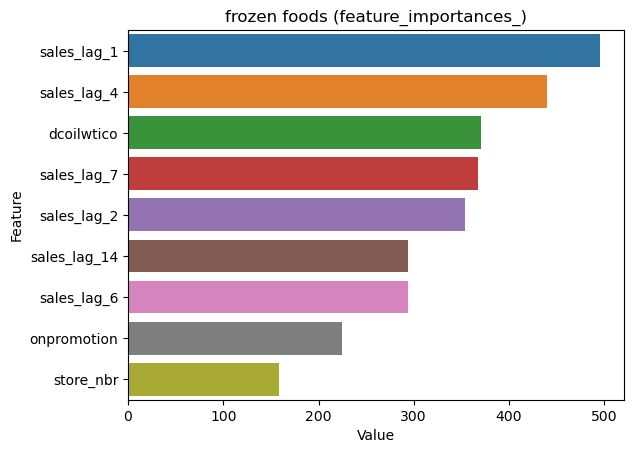

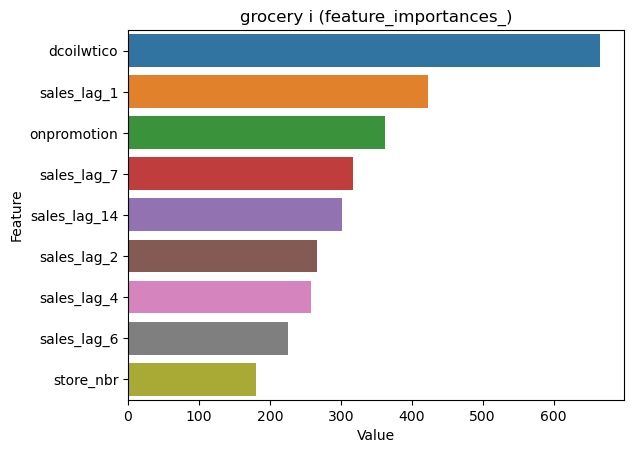

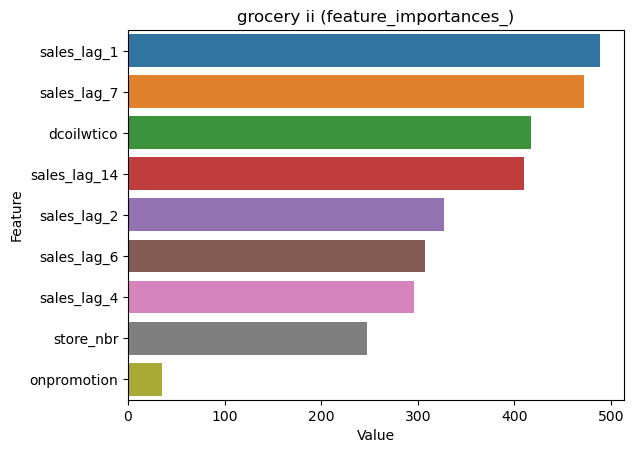

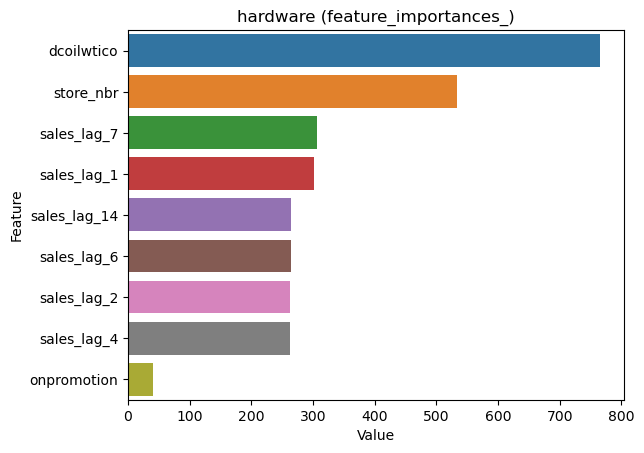

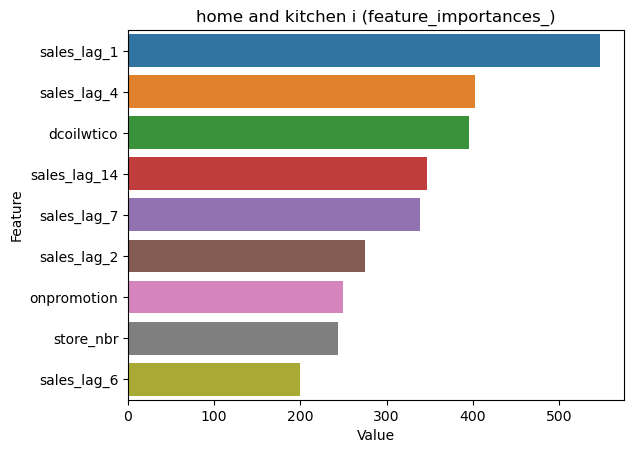

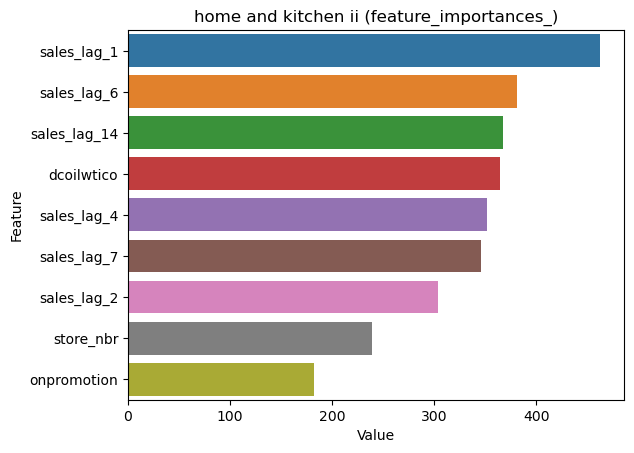

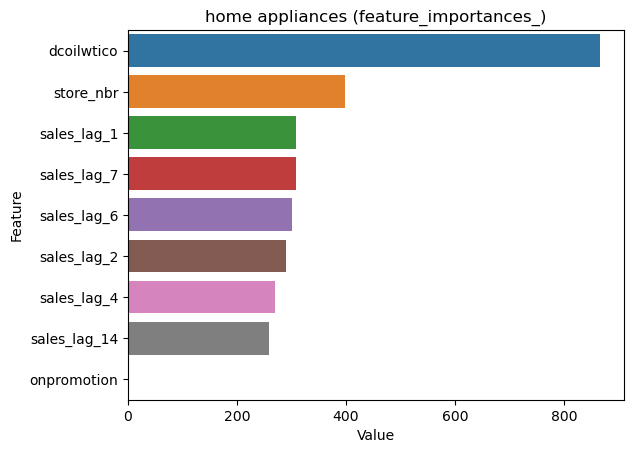

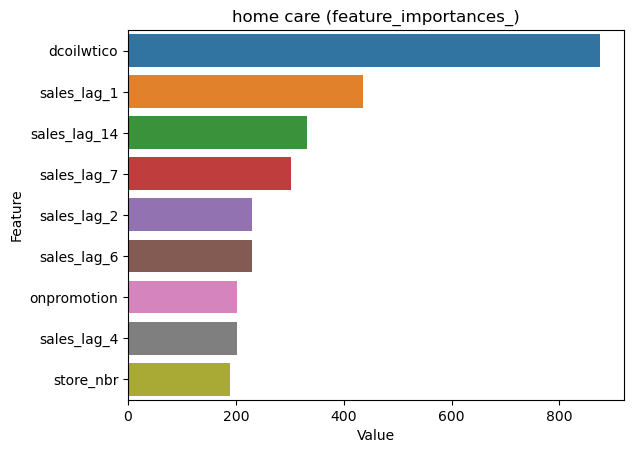

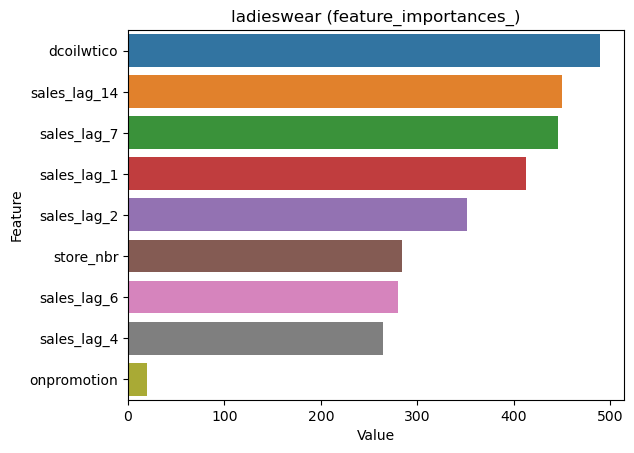

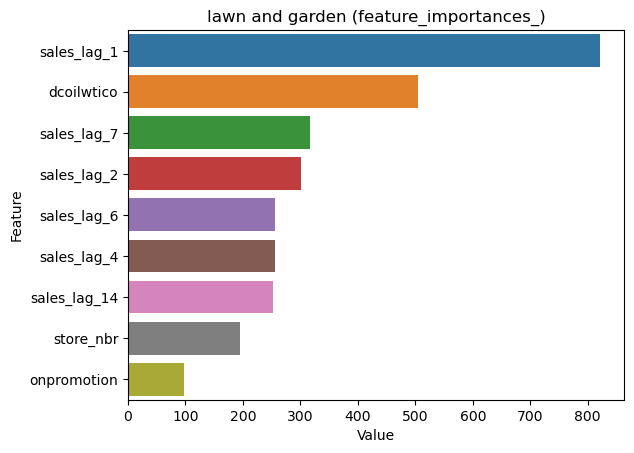

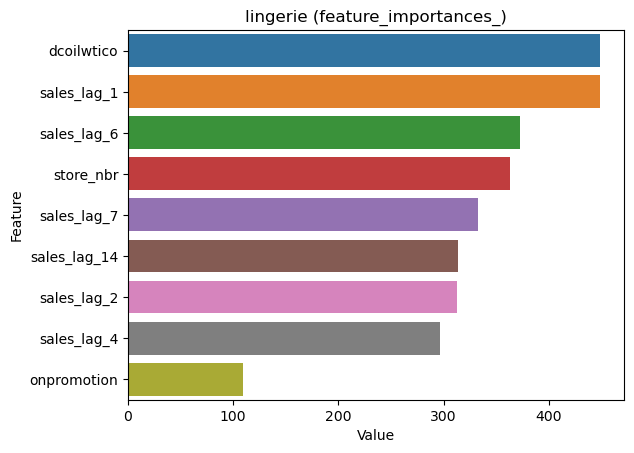

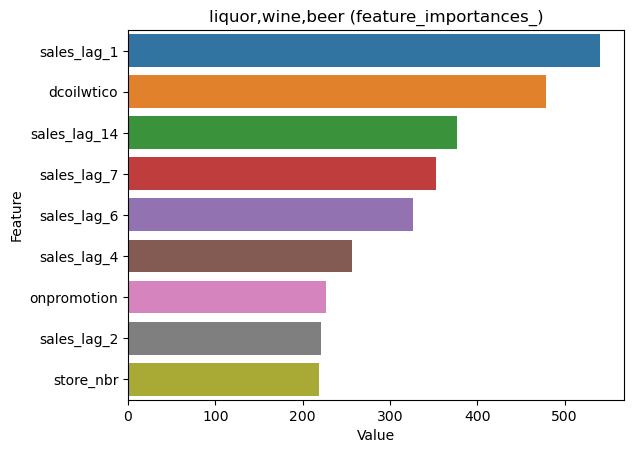

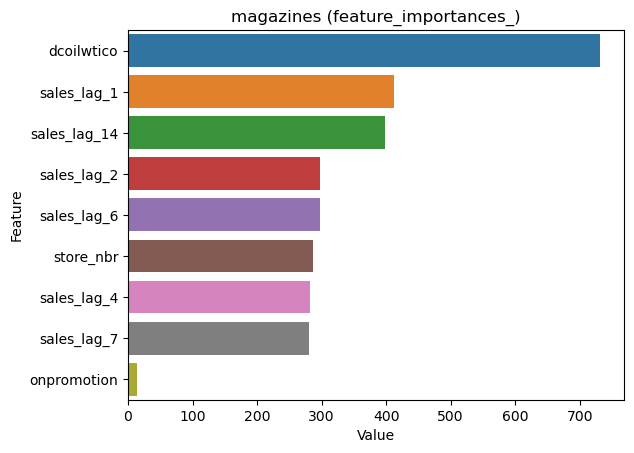

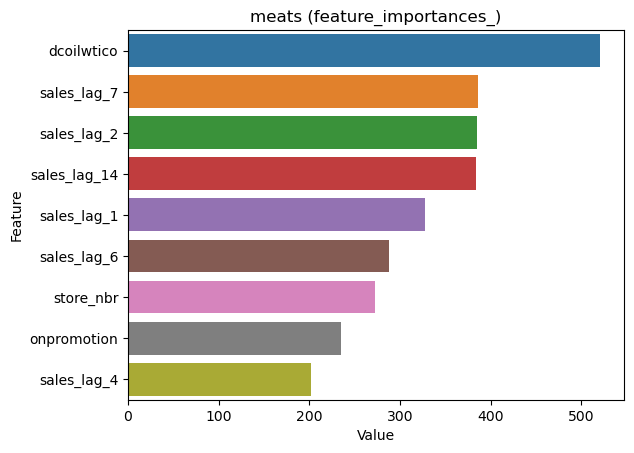

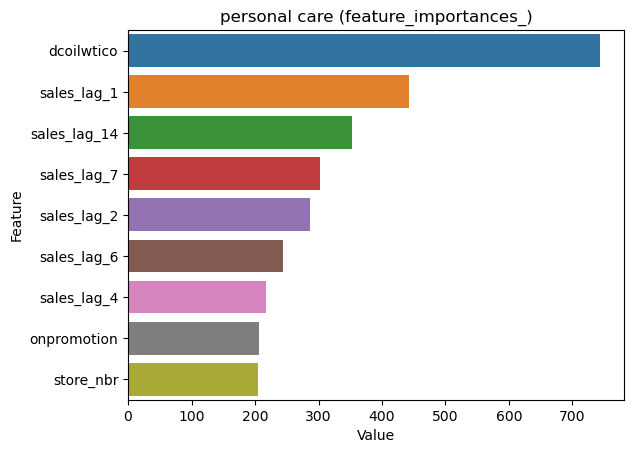

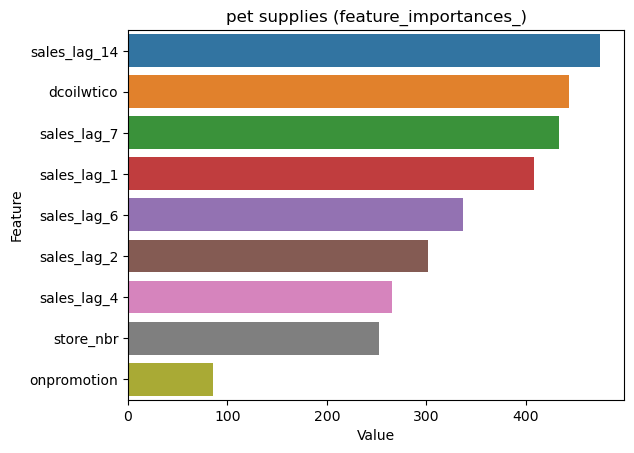

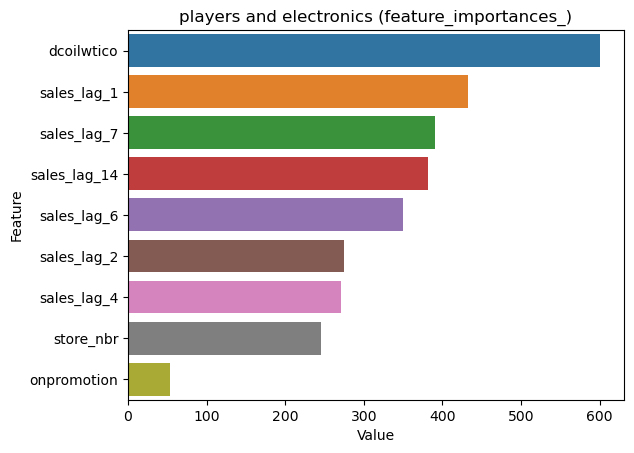

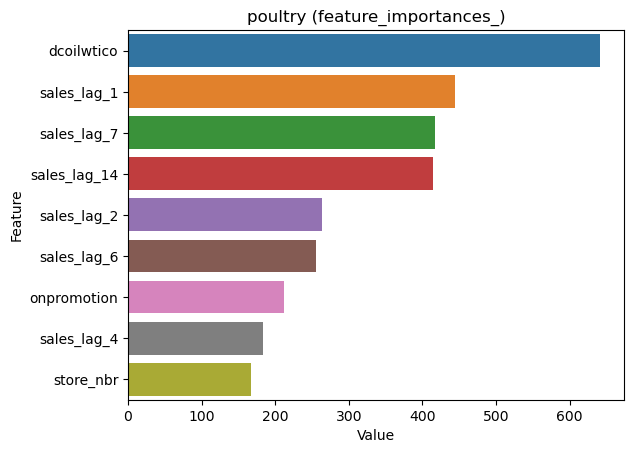

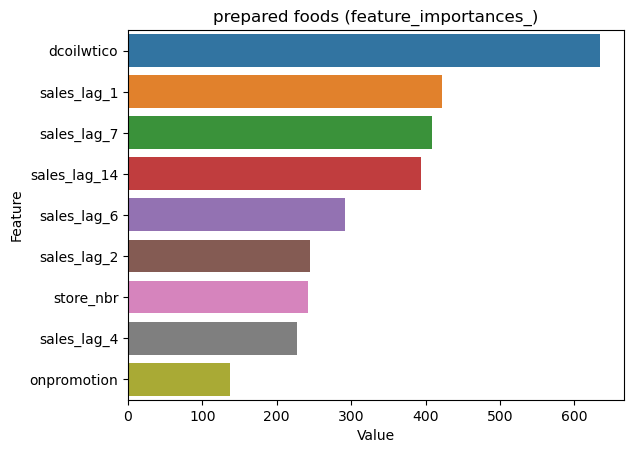

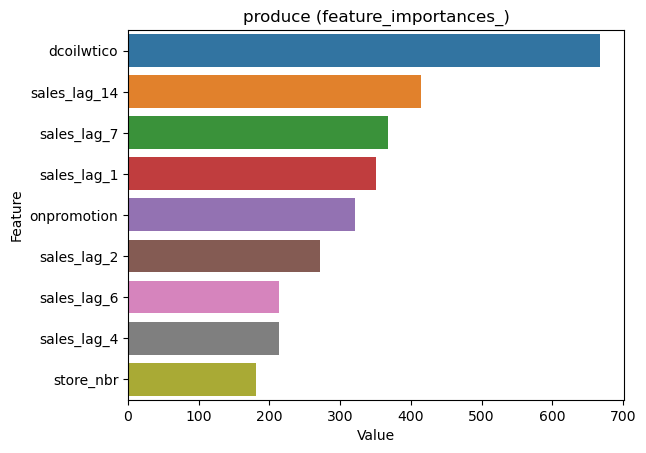

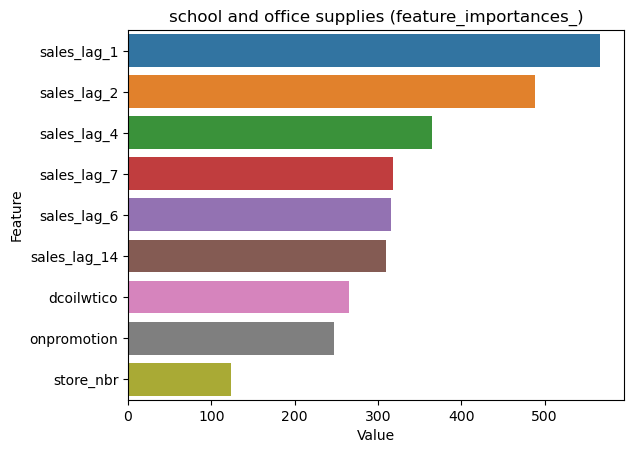

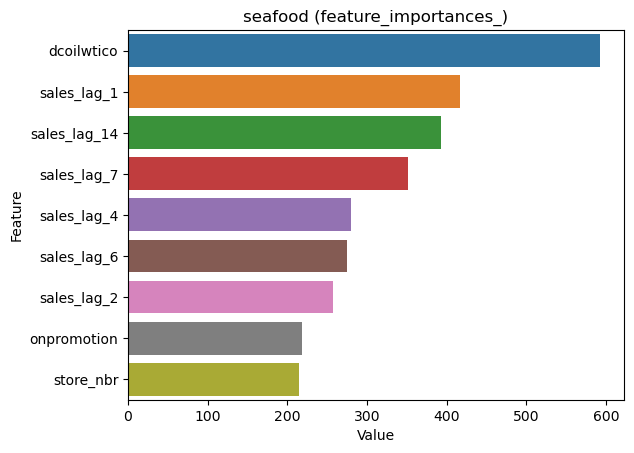

In [35]:
# lgbm.feature_importances_ on the train set of the first cv fold

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

for i, current_family in enumerate(X_train_first_fold['family'].unique()):
    X_current_family = X_train_first_fold[X_train_first_fold['family'] == current_family].drop(columns=['date', 'sales', 'family'])
    y_current_family = y_train_first_fold.loc[X_current_family.index]
    
    lgbm_model = lgb.LGBMRegressor(importance_type='split')
    lgbm_model.fit(X_current_family, y_current_family, categorical_feature=['store_nbr'])
    lgbm_feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, X_current_family.columns)), 
                                    columns=['Value', 'Feature'])
    sns.barplot(x='Value', y='Feature', data=lgbm_feature_imp.sort_values(by='Value', ascending=False))
    plt.title(f'{current_family} (feature_importances_)')
    plt.show()

#### Boruta

In [16]:
# boruta for choosing best features

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.drop(columns=['date', 'sales']).iloc[train_indices], y.iloc[train_indices]
best_features = boruta_features_tuning(X_train_first_fold, y_train_first_fold)

In [18]:
# features which will be removed from the dataset while training final model

drop_columns = {family:[feature for feature in X.drop(columns=['sales', 'date', 'family']).columns
                        if feature not in best_features[family]['green_area']]
                for family in X['family'].unique()}

In [19]:
# best_cv_params with new features set

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]
tscv_inner = TimeSeriesSplit(gap=0, max_train_size=(DAYS_IN_YEAR - 4 * N_HORIZONS) * N_STORES, n_splits=4,
                             test_size=N_HORIZONS * N_STORES)
best_cv_params_boruta = tune_hyperparams(X_train_first_fold, y_train_first_fold, tscv_inner=tscv_inner, use_rmsle=True,
                                         drop_columns=drop_columns, lags=lags, fit_params={'categorical_feature': [0]})

In [20]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                       split_key='family', target_col='sales', fit_params=fit_params, 
                                                       params=best_cv_params_boruta[current_family])
        if 'store_nbr' in drop_columns[current_family]:
            base_pipelines[current_family].fit_params = {}
            
modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise', 
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.426 ± 0.008
root_mean_squared_error: 273.149 ± 27.742
mean_absolute_error: 73.030 ± 6.091
r2: 0.955 ± 0.010


In [21]:
# best_final_params with new feature set

best_final_params_boruta = tune_hyperparams(X_train, y_train, drop_columns=drop_columns, lags=lags, tscv_inner=tscv_inner,
                                            fit_params={'categorical_feature': [0]}, use_rmsle=True)

In [22]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion'], lags=lags, split_key='family', 
                                                         target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                       split_key='family', target_col='sales', fit_params=fit_params, 
                                                       params=best_final_params_boruta[current_family])
        if 'store_nbr' in drop_columns[current_family]:
            base_pipelines[current_family].fit_params = {}
            
final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                                 zero_categories=['baby care', 'books'])

final_modelling_pipeline.fit(X_train, y_train)
make_submission_file(test_data, final_modelling_pipeline, 'optuna_LGBM_and_linreg_boruta.csv')

### Score on Kaggle: 0.43458

### Adding features from other datasets

In [12]:
X_copy = X.copy()
# X_copy['is_holiday'] = train_transformer.add_is_holiday_feature(X_copy)
X_copy = train_transformer.add_store_features(X_copy, columns_to_add=['city', 'type'])
X_copy.head()

date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0  2013-01-01          1  automotive    0.0            0         NaN   
1  2013-01-01          1   baby care    0.0            0         NaN   
2  2013-01-01          1      beauty    0.0            0         NaN   
3  2013-01-01          1   beverages    0.0            0         NaN   
4  2013-01-01          1       books    0.0            0         NaN   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_6  sales_lag_7  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   sales_lag_14  store_city  store_type  
0           NaN          18           3  
1           NaN          18           3  
2           NaN          18           3  
3           NaN          18           3  
4           NaN          18           3

In [16]:
linear_categories = ['baby care', 'books', 'lawn and garden', 'home appliances']
fit_params = {'categorical_feature': [0, -1, -2]}

base_pipelines = {}
for current_family in X_copy['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], drop_columns=['onpromotion'], lags=lags,
                                                        cols_to_encode=['store_nbr', 'store_city', 'store_type'], 
                                                        split_key='family', target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales',
                                                      fit_params=fit_params, params=best_cv_params[current_family]) 
        
modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X_copy, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, 
                        error_score='raise', n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.423 ± 0.004
root_mean_squared_error: 274.104 ± 21.301
mean_absolute_error: 73.428 ± 5.204
r2: 0.955 ± 0.007


In [17]:
X_train_copy, y_train_copy = cut_history(X=X_copy, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

In [19]:
test_data_copy = test_data.copy()
test_data_copy = test_transformer.add_store_features(test_data_copy, columns_to_add=['city', 'type'])
test_data_copy.head()

date  store_nbr      family  onpromotion  dcoilwtico  store_city  \
0  2017-08-16          1  automotive            0        46.8          18   
1  2017-08-16          1   baby care            0        46.8          18   
2  2017-08-16          1      beauty            2        46.8          18   
3  2017-08-16          1   beverages           20        46.8          18   
4  2017-08-16          1       books            0        46.8          18   

   store_type  
0           3  
1           3  
2           3  
3           3  
4           3

In [20]:
base_pipelines = {}
for current_family in X_copy['family'].unique():
    if current_family in linear_categories:
        base_pipelines[current_family] = LinearPipeline(cols_to_scale=['dcoilwtico'], cols_to_encode=['store_nbr'], 
                                                         drop_columns=['onpromotion', 'store_city', 'store_type'], lags=lags, 
                                                         split_key='family', target_col='sales')
    else:
        base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                       fit_params=fit_params, params=best_final_params[current_family])

final_modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines, 
                                                 zero_categories=['baby care', 'books'])
final_modelling_pipeline.fit(X_train_copy, y_train_copy)
make_submission_file(test_data_copy, final_modelling_pipeline, 'optuna_LGBM_and_linreg_v8.csv')

#### Conclusion: Features from other datasets (holidays, stores data) don't improve score

### Adding rolling features

In [22]:
lags = [1, 2, 4, 6, 7, 14]
rolling_days = [92, 31, 16, 10, 7, 5, 3]
rolling_aggr = {np.median: 'median', np.mean: 'mean', np.sum: 'sum', np.max: 'max'}

X = train.copy()

train_transformer = ETLTransformer(lags=lags, target_col='sales', rolling_days=rolling_days, rolling_aggr=rolling_aggr)
X, y = train_transformer.transform(X)
splitter = DateTimeSeriesSplit()

X_train, y_train = cut_history(X=X, date_column='date', keep_interval=pd.Timedelta(days=DAYS_IN_YEAR), y=y)

X.head()

date  store_nbr      family  sales  onpromotion  dcoilwtico  \
0  2013-01-01          1  automotive    0.0            0         NaN   
1  2013-01-01          1   baby care    0.0            0         NaN   
2  2013-01-01          1      beauty    0.0            0         NaN   
3  2013-01-01          1   beverages    0.0            0         NaN   
4  2013-01-01          1       books    0.0            0         NaN   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_6  sales_lag_7  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   sales_lag_14  rolling_92d_median  
0           NaN                 NaN  
1           NaN                 NaN  
2           NaN                 NaN  
3           NaN                 NaN  
4           NaN                 NaN

In [23]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv')
test_transformer = ETLTransformer(is_test=True)
test_data = test_transformer.transform(test_data)
test_data.head()

date  store_nbr      family  onpromotion  dcoilwtico
0  2017-08-16          1  automotive            0        46.8
1  2017-08-16          1   baby care            0        46.8
2  2017-08-16          1      beauty            2        46.8
3  2017-08-16          1   beverages           20        46.8
4  2017-08-16          1       books            0        46.8

In [24]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', level='store_nbr',
                                                  fit_params=fit_params, rolling_days=rolling_days, 
                                                  rolling_aggr=rolling_aggr)

modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                          zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.439 ± 0.003
root_mean_squared_error: 283.573 ± 28.477
mean_absolute_error: 79.699 ± 6.326
r2: 0.952 ± 0.009


In [19]:
# boruta

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.drop(columns=['date', 'sales']).iloc[train_indices], y.iloc[train_indices]
best_features_with_rolling = boruta_features_tuning(X_train_first_fold, y_train_first_fold)

In [21]:
drop_columns = {family:[feature for feature in X.drop(columns=['sales', 'date', 'family']).columns
                        if feature not in best_features_with_rolling[family]['green_area']]
                for family in X['family'].unique()}

In [22]:
fit_params = {'categorical_feature': [0]}

base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(lags=lags, split_key='family', target_col='sales', 
                                                   fit_params=fit_params, rolling_days=rolling_days, 
                                                   rolling_aggr=rolling_aggr, drop_columns=drop_columns[current_family])

modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise', 
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.431 ± 0.008
root_mean_squared_error: 264.425 ± 19.056
mean_absolute_error: 70.426 ± 4.798
r2: 0.958 ± 0.007


In [23]:
# for this nested cv I needed to expand train set of the first fold 
# (because I need to count rolling features with 365 days window, but train set size of the first fold is 365 days
# and it is not enough for this)

train_indices = next(splitter.split(X, y))[0]
X_train_first_fold, y_train_first_fold = X.iloc[train_indices], y.iloc[train_indices]

X_expand_train_first_fold = X[(pd.to_datetime(X['date']) >= pd.to_datetime(X_train_first_fold['date'].min()) - pd.Timedelta(days=4 * N_HORIZONS)) & 
                              (pd.to_datetime(X['date']) <= pd.to_datetime(X_train_first_fold['date'].max()))]
y_expand_train_first_fold = y.loc[X_expand_train_first_fold.index]

tscv_inner = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_STORES, n_splits=4, 
                                        test_size=N_HORIZONS * N_STORES)

best_cv_params_with_rolling = hyperparams_tuning(X_expand_train_first_fold, y_expand_train_first_fold, 
                                                 drop_columns=drop_columns, lags=lags, rolling_days=rolling_days, 
                                                 rolling_aggr=rolling_aggr, tscv_inner=tscv_inner)

In [24]:
base_pipelines = {}
for current_family in X['family'].unique():
    base_pipelines[current_family] = LGBMPipeline(drop_columns=drop_columns[current_family], lags=lags, 
                                                   split_key='family', target_col='sales',
                                                   params=best_cv_params_with_rolling[current_family], 
                                                   rolling_days=rolling_days, rolling_aggr=rolling_aggr)
            
modelling_pipeline = RecursiveTSEstimator(split_key='family', target_col='sales', base_pipelines=base_pipelines,
                                           zero_categories=['baby care', 'books'])

scores = cross_validate(modelling_pipeline, X, y, cv=splitter, scoring=CV_METRICS, return_estimator=True, error_score='raise',
                        n_jobs=-1)
format_cv_test_scores(scores)

root_mean_squared_log_error: 0.445 ± 0.007
root_mean_squared_error: 278.357 ± 24.881
mean_absolute_error: 76.906 ± 5.156
r2: 0.953 ± 0.008
